In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 25)

### **Latar Belakang**

TransJakarta sebagai sistem _Bus Rapid Transit_ (BRT) pertama di Indonesia diluncurkan pada tahun 2004 dengan tujuan menyediakan transportasi massal yang efisien, terjangkau, dan ramah lingkungan. Sistem ini dirancang untuk mengurangi ketergantungan masyarakat pada kendaraan pribadi dan meningkatkan mobilitas perkotaan.

Namun, TransJakarta menghadapi berbagai tantangan operasional yang mempengaruhi kualitas layanan. Masalah-masalah seperti: `durasi perjalanan`, `kepadatan penumpang pada jam sibuk`, `kondisi infrastruktur yang memerlukan pemeliharaan`, serta `integrasi dengan moda transportasi lain` masih menjadi perhatian utama. Kondisi ini berpengaruh terhadap kepuasan pengguna dan efektivitas sistem transportasi publik secara keseluruhan.

### **Pernyataan Masalah**

Transjakarta ingin mengetahui pola perjalanan penumpang untuk meningkatkan efisiensi operasional, khususnya dalam hal pengalokasian armada dan penjadwalan rute. Informasi ini akan membantu Transjakarta untuk `mengoptimalkan penggunaan armada`, `memperbaiki rute yang ada`, dan `mempersingkat durasi perjalanan penumpang`. Dengan menganalisis data perjalanan, perusahaan dapat merancang strategi yang lebih baik dalam merespon kebutuhan pengguna.

Sebagai seorang _data analyst_, kita akan mencoba menjawab pertanyaan berikut:

**Bagaimana cara mengalokasikan armada secara lebih efisien berdasarkan pola perjalanan penumpang bus Transjakarta?**

### **Data Understanding**

In [2]:
tj_raw = pd.read_csv('Transjakarta.csv')

In [3]:
display(
    tj_raw['tapInTime'].dtype,
    tj_raw['tapOutTime'].dtype,
    pd.to_datetime(tj_raw['tapInTime']).agg(['min','max']),
    pd.to_datetime(tj_raw['tapOutTime']).agg(['min','max'])
)

dtype('O')

dtype('O')

min   2023-04-01 06:22:27
max   2023-04-30 21:55:41
Name: tapInTime, dtype: datetime64[ns]

min   2023-04-01 07:27:31
max   2023-04-30 23:23:18
Name: tapOutTime, dtype: datetime64[ns]

##### **Dataset Dictionary**

Dataset ini berisi informasi terkait *record* penumpang BRT *(Bus Rapid Transit)* TransJakarta selama 1 bulan, tepatnya di bulan April tahun 2023.

Ada 22 kolom di dalam dataset Transjakarta, yaitu:
- `transID`         : ID transaksi unik untuk setiap transaksi.

- `payCardID`       : ID pelanggan yang tertera di kartu pembayaran.

- `payCardBank`     : Nama bank penerbit kartu pelanggan.

- `payCardName`     : Nama pelanggan yang tercatat di kartu.

- `payCardSex`      : Jenis kelamin pelanggan yang tercatat di kartu.

- `payCardBirthDate`: Tahun kelahiran pelanggan.

- `corridorID`      : ID koridor/rute sebagai kunci pengelompokkan rute.

- `corridorName`    : Nama koridor/rute, termasuk titik mulai dan selesai.

- `direction`       : 0 untuk arah pergi, 1 untuk arah kembali.

- `tapInStops`      : ID halte tap-in (masuk) untuk mengidentifikasi nama halte.

- `tapInStopsName`  : Nama halte tap-in (masuk).

- `tapInStopsLat`   : Latitude halte tap-in.

- `tapInStopsLon`   : Longitude halte tap-in.

- `stopStartSeq`    : Urutan halte yang dikunjungi, terkait dengan arah perjalanan.

- `tapInTime`       : Waktu tap-in, tanggal dan jam.

- `tapOutStops`     : ID halte tap-out (keluar) untuk mengidentifikasi nama halte.

- `tapOutStopsName` : Nama halte tap-out (keluar).

- `tapOutStopsLat`  : Latitude halte tap-out.

- `tapOutStopsLon`  : Longitude halte tap-out.

- `stopEndSeq`      : Urutan halte yang dikunjungi, terkait dengan arah perjalanan.

- `tapOutTime`      : Waktu tap-out, tanggal dan jam.

- `payAmount`       : Jumlah pembayaran yang dilakukan pelanggan, ada yang gratis, ada yang berbayar.

Berikut 5 baris teratas dan terbawah dari dataset Transjakarta.

In [4]:
display(tj_raw.head(), tj_raw.tail())

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
0,EIIW227B8L34VB,180062659848800,emoney,Bajragin Usada,M,2008,5,Matraman Baru - Ancol,1.0,P00142,Pal Putih,-6.184631,106.84402,7,2023-04-03 05:21:44,P00253,Tegalan,-6.203101,106.85715,12.0,2023-04-03 06:00:53,3500.0
1,LGXO740D2N47GZ,4885331907664776,dki,Gandi Widodo,F,1997,6C,Stasiun Tebet - Karet via Patra Kuningan,0.0,B01963P,Kemenkes 2,-6.228700,106.83302,13,2023-04-03 05:42:44,B03307P,Sampoerna Strategic,-6.217152,106.81892,21.0,2023-04-03 06:40:01,3500.0
2,DJWR385V2U57TO,4996225095064169,dki,Emong Wastuti,F,1992,R1A,Pantai Maju - Kota,0.0,B00499P,Gg. Kunir II,-6.133132,106.81435,38,2023-04-03 05:59:06,B04962P,Simpang Kunir Kemukus,-6.133731,106.81475,39.0,2023-04-03 06:50:55,3500.0
3,JTUZ800U7C86EH,639099174703,flazz,Surya Wacana,F,1978,11D,Pulo Gebang - Pulo Gadung 2 via PIK,0.0,B05587P,Taman Elok 1,-6.195743,106.93526,23,2023-04-03 05:44:51,B03090P,Raya Penggilingan,-6.183068,106.93194,29.0,2023-04-03 06:28:16,3500.0
4,VMLO535V7F95NJ,570928206772,flazz,Embuh Mardhiyah,M,1982,12,Tanjung Priok - Pluit,0.0,P00239,Sunter Boulevard Barat,-6.149650,106.88900,5,2023-04-03 06:17:35,P00098,Kali Besar Barat,-6.135355,106.81143,15.0,2023-04-03 06:57:03,3500.0


,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
37895,ZWEC949B8Q87QG,4685818286724028395,brizzi,Kamila Mahendra,F,2004,6B,Ragunan - MH Thamrin via Semanggi,1.0,P00261,Tosari,-6.196892,106.82309,2,2023-04-21 18:18:37,P00228,SMK 57,-6.290967,106.82365,13.0,2023-04-21 19:55:49,3500.0
37896,YHHK837P6Y95GN,6502902290603767,dki,Titi Siregar,M,1974,9N,Pinang Ranti - Pramuka,1.0,P00064,Garuda Taman Mini,-6.290154,106.88116,1,2023-04-18 21:52:31,P00179,Pinang Ranti,-6.291075,106.88634,2.0,2023-04-18 22:28:22,3500.0
37897,YXPP627N4G95HO,213159426675861,emoney,drg. Zahra Nashiruddin,F,1976,1T,Cibubur - Balai Kota,1.0,B02873P,Plaza Sentral,-6.216247,106.81676,12,2023-04-04 10:29:47,B00226P,Buperta Cibubur,-6.370321,106.89628,14.0,2023-04-04 13:27:25,20000.0
37898,RGVK175U2U98UV,377840859133591,emoney,Ana Agustina,M,1976,JAK.13,Tanah Abang - Jembatan Lima,1.0,B02505P,Museum Textile,-6.188656,106.80954,33,2023-04-15 19:59:26,B01787P,JPO Blok G,-6.188861,106.81135,34.0,2023-04-15 20:27:50,0.0
37899,FMZZ963S4B68ZP,501862539795,flazz,drg. Leo Najmudin,F,1985,13,Ciledug - Tendean,0.0,P00001,Adam Malik,-6.236466,106.74786,2,2023-04-12 21:08:12,P00106,Kebayoran Lama,-6.238340,106.77752,7.0,2023-04-12 21:34:53,3500.0


##### **Inspeksi Dataset**

Mari kita mulai dengan melakukan inspeksi terhadap dataset Transjakarta. Selain agar dapat lebih mengetahui isi nilai dari setiap kolomnya, kita juga berupaya untuk menemukan anomali dan cara untuk menanganinya lebih lanjut di tahapan _data cleaning._ Setiap tindakan yang dilakukan, akan disertai dengan justifikasi langkah yang diambil, baik secara _domain knowledge_ maupun secara statistik.

In [5]:
print(f'Bentuk dataset: {tj_raw.shape[0]} baris & {tj_raw.shape[1]} kolom.\n')

tj_raw.info()

Bentuk dataset: 37900 baris & 22 kolom.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37900 entries, 0 to 37899
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transID           37900 non-null  object 
 1   payCardID         37900 non-null  int64  
 2   payCardBank       37900 non-null  object 
 3   payCardName       37900 non-null  object 
 4   payCardSex        37900 non-null  object 
 5   payCardBirthDate  37900 non-null  int64  
 6   corridorID        36643 non-null  object 
 7   corridorName      35970 non-null  object 
 8   direction         37900 non-null  float64
 9   tapInStops        36687 non-null  object 
 10  tapInStopsName    37900 non-null  object 
 11  tapInStopsLat     37900 non-null  float64
 12  tapInStopsLon     37900 non-null  float64
 13  stopStartSeq      37900 non-null  int64  
 14  tapInTime         37900 non-null  object 
 15  tapOutStops       35611 non-null  object 
 16 

In [6]:
display(tj_raw.describe(), tj_raw.describe(include='object'))

,payCardID,payCardBirthDate,direction,tapInStopsLat,tapInStopsLon,stopStartSeq,tapOutStopsLat,tapOutStopsLon,stopEndSeq,payAmount
count,3.790000e+04,37900.000000,37900.000000,37900.000000,37900.000000,37900.000000,36556.000000,36556.000000,36556.000000,36893.000000
mean,4.250060e+17,1990.089314,0.500633,-6.214838,106.841554,13.572480,-6.214651,106.841233,21.219909,2699.712683
std,1.321699e+18,13.051482,0.500006,0.057911,0.060369,12.237623,0.059022,0.060999,13.800689,4212.225592
min,6.040368e+10,1946.000000,0.000000,-6.394973,106.614730,0.000000,-6.394973,106.614730,1.000000,0.000000
25%,1.800442e+14,1982.000000,0.000000,-6.245863,106.803470,4.000000,-6.247225,106.801750,11.000000,0.000000
50%,3.507947e+15,1990.000000,1.000000,-6.214587,106.834830,10.000000,-6.214718,106.834580,18.000000,3500.000000
75%,4.699023e+15,2001.000000,1.000000,-6.175528,106.882270,19.000000,-6.174736,106.883030,29.000000,3500.000000
max,4.997694e+18,2012.000000,1.000000,-6.089429,107.023950,68.000000,-6.091746,107.023660,77.000000,20000.000000


,transID,payCardBank,payCardName,payCardSex,corridorID,corridorName,tapInStops,tapInStopsName,tapInTime,tapOutStops,tapOutStopsName,tapOutTime
count,37900,37900,37900,37900,36643,35970,36687,37900,37900,35611,36556,36556
unique,37900,6,1993,2,221,216,2570,2602,37079,2230,2248,35908
top,EIIW227B8L34VB,dki,Suci Wacana,F,1T,Cibubur - Balai Kota,P00170,Penjaringan,2023-04-06 17:35:40,P00016,BKN,2023-04-24 06:53:50
freq,1,18743,80,20157,400,391,236,243,3,306,316,3


In [7]:
tj_raw.duplicated().sum()

np.int64(0)

In [8]:
pd.set_option('display.max_colwidth', 30)
unique_items = []

for col in tj_raw.columns :
    unique_items.append( [col, tj_raw[col].nunique(), tj_raw[col].unique()])

raw_desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=unique_items)
raw_desc

,Column Name,Number of Unique,Unique Sample
0,transID,37900,"[EIIW227B8L34VB, LGXO740D2..."
1,payCardID,2000,"[180062659848800, 48853319..."
2,payCardBank,6,"[emoney, dki, flazz, onlin..."
3,payCardName,1993,"[Bajragin Usada, Gandi Wid..."
4,payCardSex,2,"[M, F]"
5,payCardBirthDate,67,"[2008, 1997, 1992, 1978, 1..."
6,corridorID,221,"[5, 6C, R1A, 11D, 12, 1T, ..."
7,corridorName,216,"[Matraman Baru - Ancol, St..."
8,direction,2,"[1.0, 0.0]"
9,tapInStops,2570,"[P00142, B01963P, B00499P,..."


Dari hasil inspeksi yang telah kita lakukan, dapat disimpulkan bahwa:

- Dataset Transjakarta memiliki 37.900 baris & 22 kolom
- beberapa kolom, seperti: `corridorID`, `corridorName`, `tapInStops`, `tapOutStops`, `tapOutStopsName`, `tapOutStopsLat`, `tapOutStopsLon`, `stopEndSeq`, `tapOutTime`, dan `payAmount` memiliki data kosong. Data kosong pada kolom-kolom tersebut diwakili dengan data `NaN`.
- Kolom `transID` memiliki 37900 nilai unik, sesuai dengan panjang dataset Transjakarta. Dari sini terlihat bahwa tidak terdapat transaksi duplikat pada dataset ini, yang berarti kolom `payCardID	` dan `payCardName` menunjukkan bahwa terdapat penumpang yang sama dan menggunakan layanan Transjakarta secara berkala.
- Kolom `payCardID`, `tapInStops`, dan `tapOutStops` berisikan ID unik untuk setiap kartu pembayaran, halde tap-in/tap-out penumpang, yang sudah terwakilkan keterangannya pada beberapa kolom lain. Oleh karena itu kolom `transID`, `tapInStops`, dan `tapOutStops` kurang relevan untuk analisis dan dapat kita _drop_ saja.
= Kolom `tapInTime` dan `tapOutTime` lebih cocok untuk kita analisa dengan cara kita ubah tipe datanya dari `object` menjadi `datetime`.
- Beberapa kolom seperti: `tapOutStopsName, tapOutStopsLat, tapOutStopsLon, stopEndSeq, tapOutTime` mengandung jumlah `NaN` yang sama. Kita dapat asumsikan diawal bahwa setiap _missing value_ dari 5 kolom tersebut berada di _row_ yang sama. Kita akan cek dan pastikan lebih lanjut.
- Kolom `payCardBirthDate` dapat kita manfaatkan untuk mencari umur dari setiap penumpang (`2023 - payCardBirthDate`). Kita sesuaikan dimensi waktu karena dataset ini hanya berisikan *records* penumpang Transjakarta di bulan April tahun 2023.

### **Data Cleansing**

Kita *assign* dataset Transjakarta ke variabel baru, agar perubahan yang kita lakukan `tidak memberikan efek ke file dataset raw`. Disisi lain, hal ini juga menjadi `tindakan preventif` bagi kita. Jika sewaktu-waktu kita melakukan perubahan yang `berakibat fatal` ke proses analisis, kita dapat kembali ke bentuk dataset yang masih *raw* dengan aman.

In [9]:
df_tj = tj_raw.copy()

Mari kita investigasi lebih lanjut untuk memastikan apakah terdapat duplikat data atau tidak.

In [10]:
# df_tj[df_tj['payCardID'].duplicated()].head() # 4885331907664776, dki, Gandi Widodo, Sawo Kecik Raya, 2023-04-03 17:35:45, 2023-04-03 19:00:15

df_tj[df_tj['payCardID'].duplicated(keep=False)].head()

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
0,EIIW227B8L34VB,180062659848800,emoney,Bajragin Usada,M,2008,5,Matraman Baru - Ancol,1.0,P00142,Pal Putih,-6.184631,106.84402,7,2023-04-03 05:21:44,P00253,Tegalan,-6.203101,106.85715,12.0,2023-04-03 06:00:53,3500.0
1,LGXO740D2N47GZ,4885331907664776,dki,Gandi Widodo,F,1997,6C,Stasiun Tebet - Karet via ...,0.0,B01963P,Kemenkes 2,-6.228700,106.83302,13,2023-04-03 05:42:44,B03307P,Sampoerna Strategic,-6.217152,106.81892,21.0,2023-04-03 06:40:01,3500.0
2,DJWR385V2U57TO,4996225095064169,dki,Emong Wastuti,F,1992,R1A,Pantai Maju - Kota,0.0,B00499P,Gg. Kunir II,-6.133132,106.81435,38,2023-04-03 05:59:06,B04962P,Simpang Kunir Kemukus,-6.133731,106.81475,39.0,2023-04-03 06:50:55,3500.0
3,JTUZ800U7C86EH,639099174703,flazz,Surya Wacana,F,1978,11D,Pulo Gebang - Pulo Gadung ...,0.0,B05587P,Taman Elok 1,-6.195743,106.93526,23,2023-04-03 05:44:51,B03090P,Raya Penggilingan,-6.183068,106.93194,29.0,2023-04-03 06:28:16,3500.0
4,VMLO535V7F95NJ,570928206772,flazz,Embuh Mardhiyah,M,1982,12,Tanjung Priok - Pluit,0.0,P00239,Sunter Boulevard Barat,-6.149650,106.88900,5,2023-04-03 06:17:35,P00098,Kali Besar Barat,-6.135355,106.81143,15.0,2023-04-03 06:57:03,3500.0


In [11]:
display(df_tj['transID'].duplicated().sum(), df_tj['payCardID'].duplicated().sum(), df_tj['payCardName'].duplicated().sum())

np.int64(0)

np.int64(35900)

np.int64(35907)

Dari sini terlihat bahwa duplikasi data berasal dari *loyal customer*, yaitu penumpang yang secara rutin memang menggunakan layanan Transjakarta untuk opsi transportasi utama mereka. Oleh karena itu kita tidak akan menghapusnya karena *records* tersebut merupakan data yang valid.

##### **Missing Value Check**

In [12]:
df_missing = pd.DataFrame(df_tj.isna().sum()).rename(columns={0:'missingCount'})
df_missing['missingPercentage'] = round((df_missing['missingCount'] / len(df_tj)), 4) * 100
df_missing

,missingCount,missingPercentage
transID,0,0.00
payCardID,0,0.00
payCardBank,0,0.00
payCardName,0,0.00
payCardSex,0,0.00
payCardBirthDate,0,0.00
corridorID,1257,3.32
corridorName,1930,5.09
direction,0,0.00
tapInStops,1213,3.20


##### **Missing Value Distribution Check**

<Axes: >

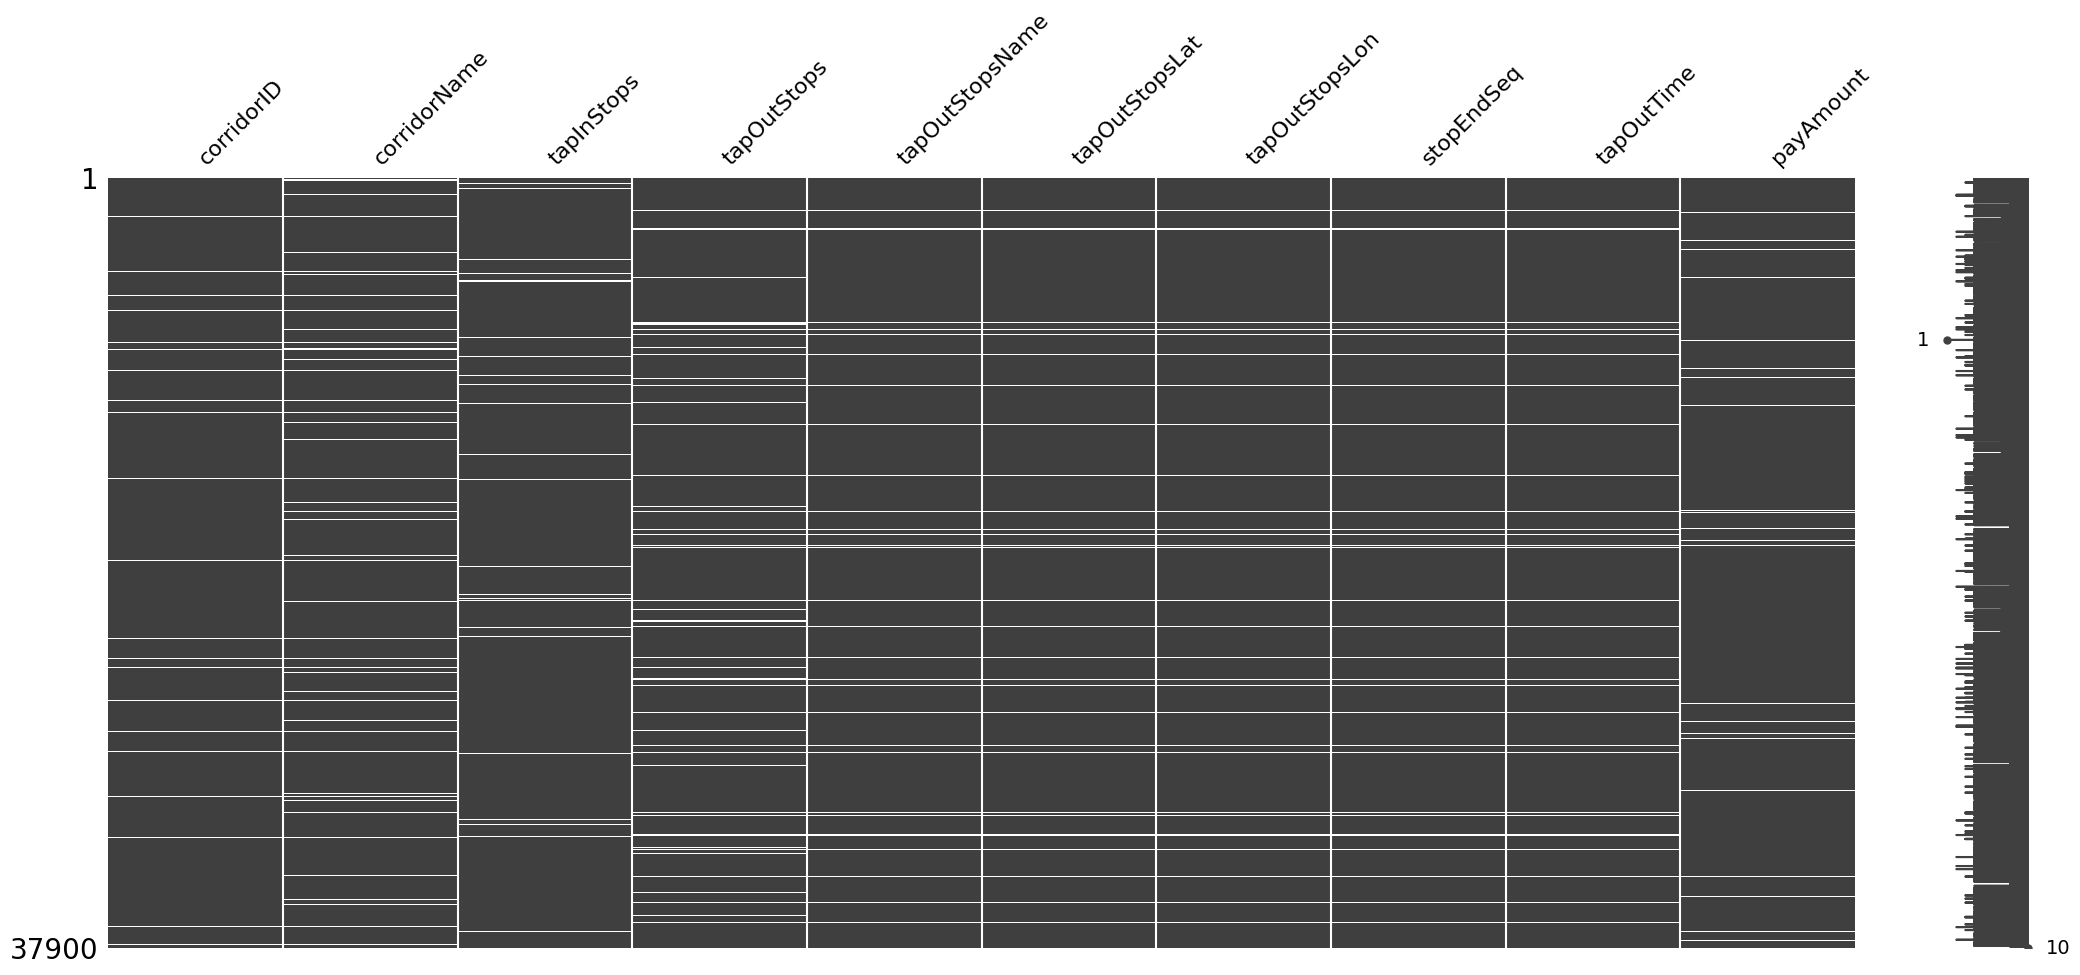

In [13]:
msno.matrix(df_tj[
                  ['corridorID', 'corridorName',
                  'tapInStops',
                  'tapOutStops', 'tapOutStopsName',
                  'tapOutStopsLat', 'tapOutStopsLon',
                  'stopEndSeq', 'tapOutTime',
                  'payAmount']
                  ]
            )

<Axes: >

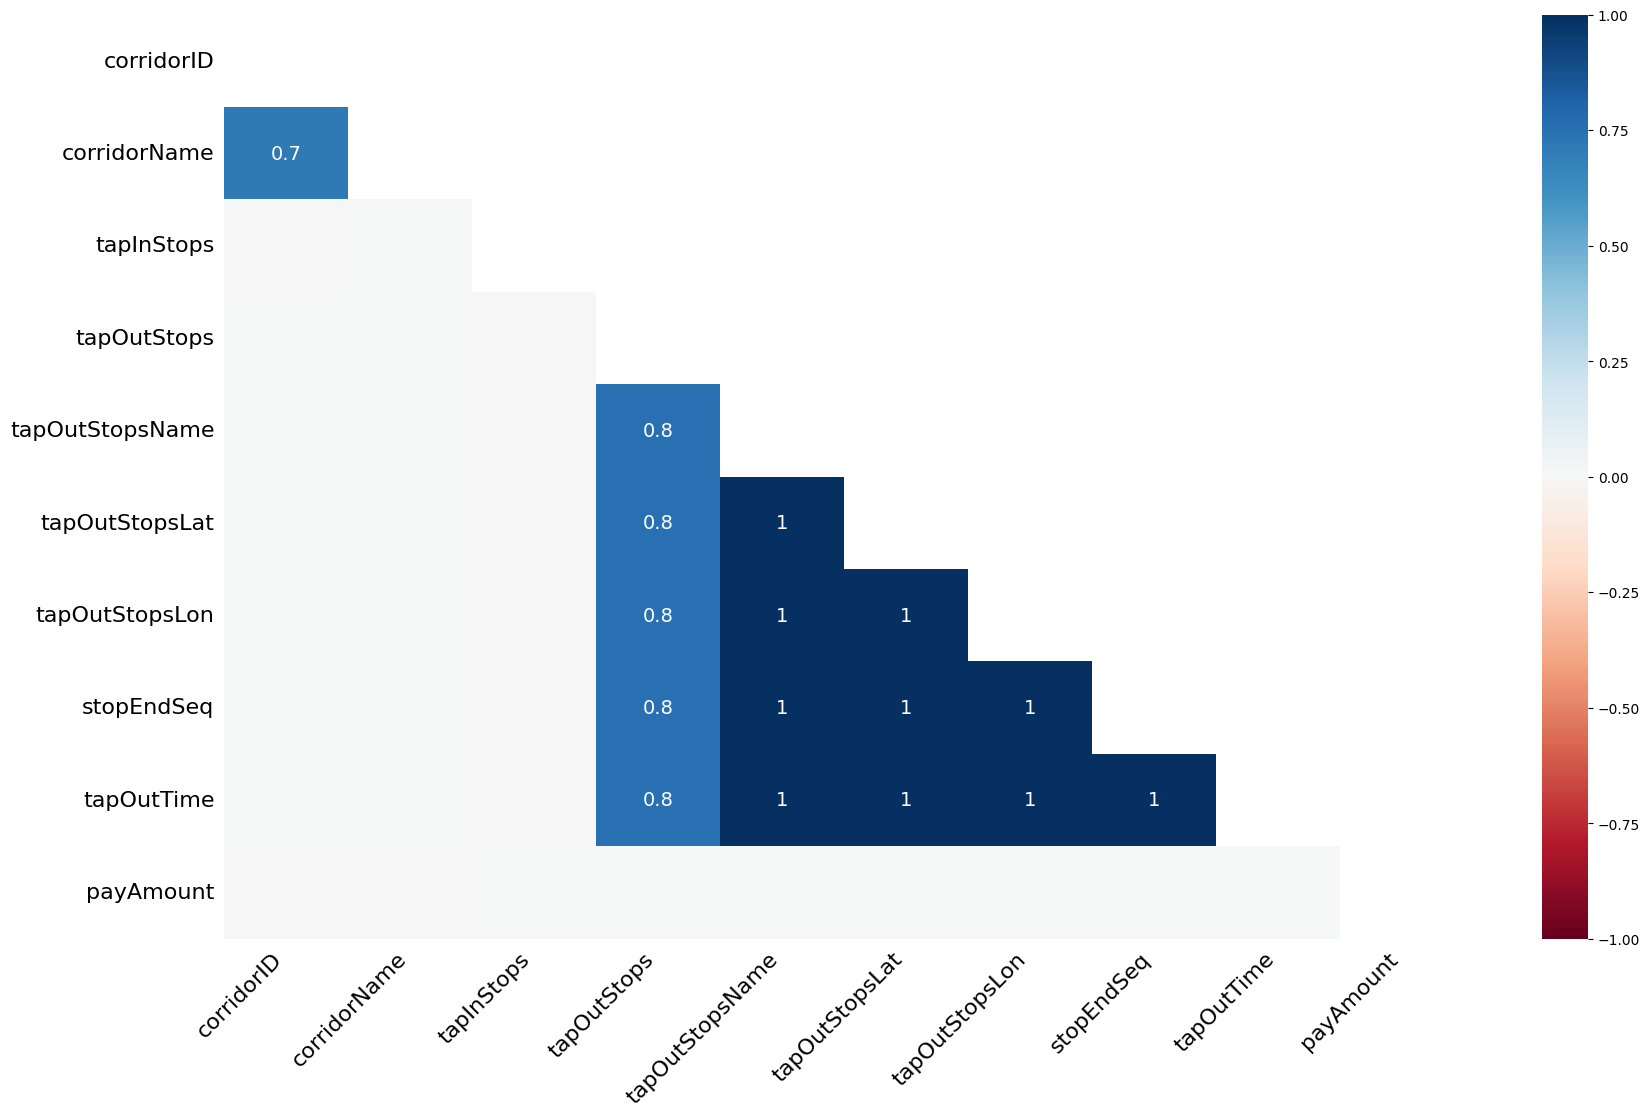

In [14]:
msno.heatmap(df_tj)

Secara garis besar:  
* Persentase *missing value* dari dataset Transjakarta hanya terdiri _kurang dari 10%_ dari setiap kolomnya. Dengan kolom `tapOutStops` yang memiliki _missing value_ terbanyak dengan persentase sebesar 6.04%
* *missing value* di kolom : `tapOutStopsName, tapOutStopsLat, tapOutStopsLon`, dan kolom `stopEndSeq` memiliki *missing values* yang saling berkaitan. Dengan kata lain, *missing value* dari berbagai kolom ini berada di row yang sama.

Ada beberapa cara untuk menangani *missing value*:

1. Jika persentase missing < 5% : `delete row`
1. 5-20% : `simple imputation` (mean, median, modus, constant)
1. 20-50% : `advanced immputer` (KKN, iterative imputer)
1. Jika persentase missing > 50% : `delete column`

* Kolom `corridorID`, `tapInStops`, dan `tapOutStops` dapat kita *drop*/biarkan saja karena bukan termasuk bagian yang dapat kita analisis (*column to drop*)
* Untuk `tapOutStopsName, tapOutStopsLat, tapOutStopsLon`, dan kolom `stopEndSeq`, tidak bisa langsung kita `dropna` karena *missing value* dari kolom-kolom tersebut saling berkaitan. Oleh karena itu, kita perlu melakukan imputasi untuk mengisi *missing value*.
* *Missing value* di kolom `payAmount` juga masih dapat kita isi dengan *domain knowledge* tarif Transjakarta yaitu dengan harga *flat* 3500 untuk setiap kali *tap in*. Dimana kita asumsikan, seharusnya *median* dan *mode* dari kolom `payAmount` juga merupakan 3500.

##### **Handle Missing Value**

Kita akan mulai mencoba imputasi ke kolom kategori yang terdapat *missing values* yaitu: `corridorName` dan `tapOutStopsName`. Mari kita mulai dari kolom `tapOutStopsName` karena kolom ini akan menjadi acuan saat kita imputasi kolom `corridorName` selanjutnya.

Untuk cara imputasi yang kita gunakan adalah mencoba mengisi *missing values* dengan menjadikan kolom lain sebagai acuan `SimpleImputer (most_frequent)`.

Imputasi akan dilakukan dengan data yang sudah ada, berdasarkan kolom-kolom yang saling berkorelasi, ataupun dengan *domain knowledge*. Tujuan imputasi ini agar persentase *missing values* pada dataset Transjakarta tidak ada yang melebihi 5%. Terakhir, dari sisa-sisa dari *missing values* nantinya dapat kita *drop*.

In [15]:
# df_tj.groupby(['direction','tapInStopsName'])['tapOutStopsName'] \
#     .transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)

In [16]:
mode_imputer = SimpleImputer(strategy='most_frequent')

df_tj['tapOutStopsName'] = df_tj.groupby(['direction','tapInStopsName'])['tapOutStopsName'] \
    .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() if not x.mode().empty else x)

In [17]:
display(
    tj_raw['tapOutStopsName'].isna().sum(), 
    df_tj['tapOutStopsName'].isna().sum()
)

np.int64(1344)

np.int64(46)

Selanjutnya kita coba isi *missing values* di kolom `corridorName` dengan menjadikan kolom `tapinStopsName` dan `tapOutStopsName` sebagai acuannya.

In [18]:
df_tj['corridorName'] = df_tj.groupby(['direction','tapInStopsName','tapOutStopsName'])['corridorName'] \
    .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() if not x.mode().empty else x)

In [19]:
display(
    tj_raw[['corridorName','tapOutStopsName']].isna().sum(), 
    df_tj[['corridorName','tapOutStopsName']].isna().sum()
)

corridorName       1930
tapOutStopsName    1344
dtype: int64

corridorName       174
tapOutStopsName     46
dtype: int64

Kita coba cek hasilnya apakah masuk akal atau tidak berdasarkan *domain knowledge* kita terhadap daerah dan ruas jalan di kota Jakarta.

In [20]:
display(
    tj_raw[(tj_raw['corridorName'].isna()) & (tj_raw['tapOutStopsName'].isna())][['corridorName','direction','tapInStopsName','tapOutStopsName']].head(),
    df_tj.iloc[[826,837,876,1395,2646]][['corridorName','direction','tapInStopsName','tapOutStopsName']]
    )

,corridorName,direction,tapInStopsName,tapOutStopsName
826,NaN,1.0,Stasiun Jatinegara Arah Utara,NaN
837,NaN,0.0,Ragunan,NaN
876,NaN,1.0,Jln. Prima,NaN
1395,NaN,1.0,Cut Meutia,NaN
2646,NaN,0.0,Tol Bekasi Timur 1,NaN


,corridorName,direction,tapInStopsName,tapOutStopsName
826,Tanjung Priok - PGC 2,1.0,Stasiun Jatinegara Arah Utara,Permai Koja Arah Utara
837,Ragunan - Gelora Bung Karno,0.0,Ragunan,Tendean
876,Rawa Buaya - Rawa Kompeni,1.0,Jln. Prima,Sbr. SMAN 95
1395,Gondangdia - Senen,1.0,Cut Meutia,Selatan St. Gondangdia
2646,Bekasi Timur - Cawang,0.0,Tol Bekasi Timur 1,BNN LRT


Selanjutnya kita akan coba `IterativeImputer` terhadap kolom numerik seperti `tapOutStopsLat`, `tapOutStopsLon`, `stopEndSeq`, dan `tapOutTime` dengan mengacu kepada empat kolom saat penumpang melakukan *tap-in.*

**TapOutStopsLat & TapOutStopsLat**

In [21]:
col_to_validate = ['corridorName','direction','stopStartSeq','tapInTime','tapOutStopsLat','tapOutStopsLon','stopEndSeq','tapOutTime','payAmount']

In [22]:
# Define imputer
iter_imputer = IterativeImputer()

# Fit imputer
iter_imputer.fit(df_tj[['tapOutStopsLat','tapInStopsLat']])

,estimator,None
,missing_values,nan
,sample_posterior,False
,max_iter,10
,tol,0.001
,n_nearest_features,None
,initial_strategy,'mean'
,fill_value,None
,imputation_order,'ascending'
,skip_complete,False
,min_value,-inf


In [23]:
# Transform
df_tj['tapOutStopsLat'] = iter_imputer.transform(df_tj[['tapOutStopsLat','tapInStopsLat']])
df_tj['tapOutStopsLat'] = df_tj['tapOutStopsLat'].astype('float64')

In [24]:
iter_imputer.fit(df_tj[['tapOutStopsLon','tapInStopsLon']])

,estimator,None
,missing_values,nan
,sample_posterior,False
,max_iter,10
,tol,0.001
,n_nearest_features,None
,initial_strategy,'mean'
,fill_value,None
,imputation_order,'ascending'
,skip_complete,False
,min_value,-inf


In [25]:
df_tj['tapOutStopsLon'] = iter_imputer.transform(df_tj[['tapOutStopsLon','tapInStopsLon']])
df_tj['tapOutStopsLon'] = df_tj['tapOutStopsLon'].astype('float64')

**StopEndSeq**

In [26]:
iter_imputer.fit(df_tj[['stopEndSeq','stopStartSeq']])

,estimator,None
,missing_values,nan
,sample_posterior,False
,max_iter,10
,tol,0.001
,n_nearest_features,None
,initial_strategy,'mean'
,fill_value,None
,imputation_order,'ascending'
,skip_complete,False
,min_value,-inf


In [27]:
df_tj['stopEndSeq'] = iter_imputer.transform(df_tj[['stopEndSeq','stopStartSeq']])
df_tj['stopEndSeq'] = df_tj['stopEndSeq'].astype('int64')

Mari kita cek hasilnya

In [28]:
display(
    tj_raw[tj_raw['stopEndSeq'].isna()][col_to_validate].head(),
    df_tj.iloc[[6,30,70,130,192]][col_to_validate]
    )

,corridorName,direction,stopStartSeq,tapInTime,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
6,Kalibata - Kuningan,0.0,25,2023-04-03 06:58:21,NaN,NaN,NaN,NaN,0.0
30,Pasar Minggu - Jagakarsa,1.0,19,2023-04-03 06:14:02,NaN,NaN,NaN,NaN,0.0
70,Cibubur - Balai Kota,0.0,7,2023-04-03 05:57:55,NaN,NaN,NaN,NaN,20000.0
130,Kampung Rambutan - Tanjung...,0.0,7,2023-04-03 05:40:04,NaN,NaN,NaN,NaN,3500.0
192,Kalideres - Gelora Bung Karno,0.0,11,2023-04-03 06:15:53,NaN,NaN,NaN,NaN,3500.0


,corridorName,direction,stopStartSeq,tapInTime,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
6,Kalibata - Kuningan,0.0,25,2023-04-03 06:58:21,-6.223368,106.850358,31,NaN,0.0
30,Pasar Minggu - Jagakarsa,1.0,19,2023-04-03 06:14:02,-6.291958,106.832726,26,NaN,0.0
70,Cibubur - Balai Kota,0.0,7,2023-04-03 05:57:55,-6.207782,106.823527,15,NaN,20000.0
130,Kampung Rambutan - Tanjung...,0.0,7,2023-04-03 05:40:04,-6.169748,106.875205,15,NaN,3500.0
192,Kalideres - Gelora Bung Karno,0.0,11,2023-04-03 06:15:53,-6.159427,106.747950,18,NaN,3500.0


**tapOutTime**

Kemudian kita akan isi *missing values* di kolom `tapOutTime` berdasarkan nilai rata-rata durasi perjalanan penumpang dari `tapInTime` + nilai `mean` atau `median`. 

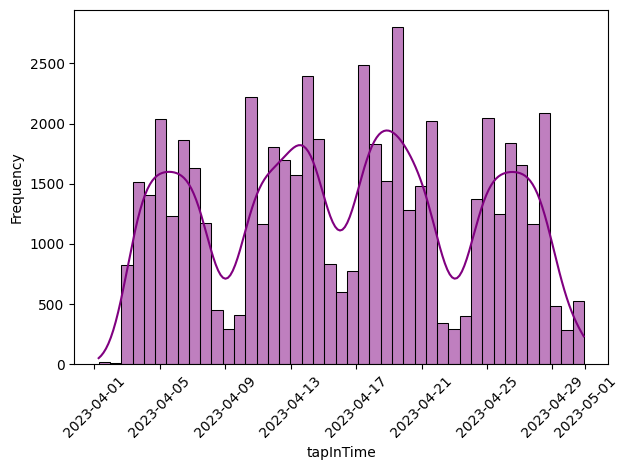

In [29]:
sns.histplot(df_tj['tapInTime'].astype('datetime64[ns]'), kde=True, stat='frequency', color='purple')
plt.xticks(rotation=45)
plt.tight_layout();

In [30]:
# Casting tipe data

df_tj['tapInTime'] = pd.to_datetime(df_tj['tapInTime'], format='%Y-%m-%d %H:%M:%S')
df_tj['tapOutTime'] = pd.to_datetime(df_tj['tapOutTime'], format='%Y-%m-%d %H:%M:%S')

df_tj[['tapInTime','tapOutTime']].dtypes

tapInTime     datetime64[ns]
tapOutTime    datetime64[ns]
dtype: object

In [31]:
display(
    df_tj['tapInTime'].dt.hour.agg(['min','max']),
    df_tj['tapOutTime'].dt.hour.agg(['min','max'])
)

min     5
max    21
Name: tapInTime, dtype: int32

min     0.0
max    23.0
Name: tapOutTime, dtype: float64

In [32]:
display(
    df_tj[(df_tj['tapInTime'].dt.hour == 5) & (df_tj['tapInTime'].dt.minute < 1)][:1],
    df_tj[df_tj['tapOutTime'].dt.hour < 4]
)

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
149,OVAQ760H7C61IE,4946777822784,online,Wirda Yuliarti,M,1990,5,Matraman Baru - Ancol,0.0,P00224,Slamet Riyadi,-6.208533,106.85929,1,2023-04-03 05:00:14,NaN,Budi Utomo,-6.166063,106.83906,9,2023-04-03 05:33:29,3500.0


,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
37615,JEES739W6T40LL,3563362178943707,dki,drg. Michelle Puspita,F,1968,2E,Rusun Rawa Bebek - Kodamar,0.0,B00554P,Gg. Sawo 1,-6.20176,106.93513,11,2023-04-24 21:46:56,B01850P,Kayu Mas,-6.17911,106.90255,25,2023-04-25 00:30:08,0.0


Setelah kita selesai *casting* tipe data di kolom `tapInTime` dan `tapOutTime` menjadi `datetime64[ns]`, sekarang kita coba cari `mean` dari durasi perjalanan penumpang Transjakarta.

In [33]:
display(
    round((df_tj['tapOutTime'] - df_tj['tapInTime']).dt.total_seconds().median() / 60, 2),
    round((df_tj['tapOutTime'] - df_tj['tapInTime']).dt.total_seconds().mean() / 60, 2)
)

np.float64(71.83)

np.float64(72.13)

Meskipun perbedaannya sangat kecil antara `mean` dan `median` dari durasi perjalanan penumpang Transjakarta, kita akan gunakan `median` agar lebih sesuai dengan bentuk persebaran datanya.

In [34]:
median_dur = round((df_tj['tapOutTime'] - df_tj['tapInTime']).dt.total_seconds().median() / 60, 2)

print(f'Rata-rata durasi perjalanan penumpang: {median_dur} menit')

Rata-rata durasi perjalanan penumpang: 71.83 menit


In [35]:
df_tj['tapOutTime'] = df_tj['tapOutTime'].fillna(df_tj['tapInTime'].apply(lambda x: x + pd.Timedelta(minutes=int(median_dur))))

Mari kita cek hasilnya

In [36]:
display(tj_raw[tj_raw['tapOutTime'].isna()][col_to_validate].head(), \
        df_tj.iloc[[6,30,70,130,192]][col_to_validate])

,corridorName,direction,stopStartSeq,tapInTime,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
6,Kalibata - Kuningan,0.0,25,2023-04-03 06:58:21,NaN,NaN,NaN,NaN,0.0
30,Pasar Minggu - Jagakarsa,1.0,19,2023-04-03 06:14:02,NaN,NaN,NaN,NaN,0.0
70,Cibubur - Balai Kota,0.0,7,2023-04-03 05:57:55,NaN,NaN,NaN,NaN,20000.0
130,Kampung Rambutan - Tanjung...,0.0,7,2023-04-03 05:40:04,NaN,NaN,NaN,NaN,3500.0
192,Kalideres - Gelora Bung Karno,0.0,11,2023-04-03 06:15:53,NaN,NaN,NaN,NaN,3500.0


,corridorName,direction,stopStartSeq,tapInTime,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
6,Kalibata - Kuningan,0.0,25,2023-04-03 06:58:21,-6.223368,106.850358,31,2023-04-03 08:09:21,0.0
30,Pasar Minggu - Jagakarsa,1.0,19,2023-04-03 06:14:02,-6.291958,106.832726,26,2023-04-03 07:25:02,0.0
70,Cibubur - Balai Kota,0.0,7,2023-04-03 05:57:55,-6.207782,106.823527,15,2023-04-03 07:08:55,20000.0
130,Kampung Rambutan - Tanjung...,0.0,7,2023-04-03 05:40:04,-6.169748,106.875205,15,2023-04-03 06:51:04,3500.0
192,Kalideres - Gelora Bung Karno,0.0,11,2023-04-03 06:15:53,-6.159427,106.747950,18,2023-04-03 07:26:53,3500.0


In [37]:
# Perbandingan dengan corridorID
display(
    tj_raw.groupby(['direction','tapInStopsName','tapOutStopsName'])['corridorName'] \
        .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() \
        if not x.mode().empty else x).isna().sum(), # 1473
    tj_raw.groupby(['corridorID','tapInStopsName','tapOutStopsName'])['corridorName'] \
        .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() \
        if not x.mode().empty else x).isna().sum() # 2605
)
# Perbandingan dengan tapInStops
display(
    tj_raw.groupby(['direction','tapOutStopsName'])['tapInStopsName'] \
        .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() \
        if not x.mode().empty else x).isna().sum(), # 1344
    tj_raw.groupby(['tapInStops','tapOutStopsName'])['tapInStopsName'] \
        .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() \
        if not x.mode().empty else x).isna().sum() # 2521
)
# Perbandingan dengan tapOutStops
display(
    tj_raw.groupby(['direction','tapInStopsName'])['tapOutStopsName'] \
        .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() \
        if not x.mode().empty else x).isna().sum(), # 46
    tj_raw.groupby(['tapOutStops','tapInStopsName'])['tapOutStopsName'] \
        .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() \
        if not x.mode().empty else x).isna().sum() # 2289
)

np.int64(1473)

np.int64(2605)

np.int64(1344)

np.int64(2521)

np.int64(46)

np.int64(2289)

Tampaknya imputasi lebih efisien jika kita lakukan tanpa mengandalkan kolom `corridorID`, `tapInStops`, dan `tapOutStops`. Berarti ketiga kolom ini memang tidak relevan untuk analisa dan tidak dapat kita manfaatkan juga. Oleh karena itu mari kita *drop* ketiga kolom ini.

In [38]:
df_tj = df_tj.drop(columns=['corridorID','tapInStops','tapOutStops'], axis=1)
df_tj.columns

Index(['transID', 'payCardID', 'payCardBank', 'payCardName', 'payCardSex',
       'payCardBirthDate', 'corridorName', 'direction', 'tapInStopsName',
       'tapInStopsLat', 'tapInStopsLon', 'stopStartSeq', 'tapInTime',
       'tapOutStopsName', 'tapOutStopsLat', 'tapOutStopsLon', 'stopEndSeq',
       'tapOutTime', 'payAmount'],
      dtype='object')

Sekarang kita coba mengisi *missing values* di kolom `payAmount` yang bertipe numerik. Mari kita awali dengan melakukan *plot* agar dapat mengetahui bentuk distribusi datanya.

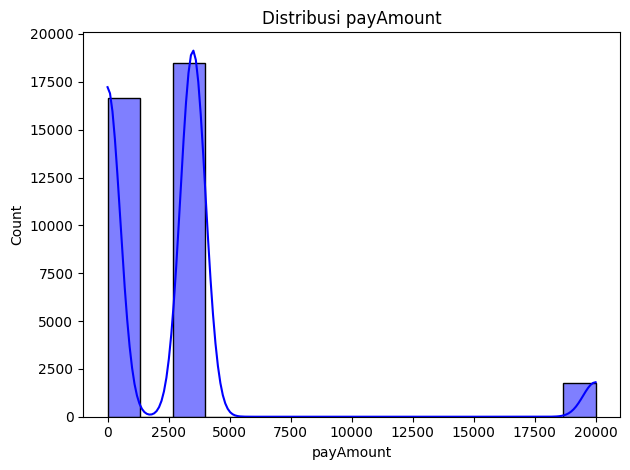

In [39]:
sns.histplot(df_tj['payAmount'], kde=True, bins=15, color='b')
plt.title('Distribusi payAmount')

plt.tight_layout();

Terlihat bahwa distribusi data pada kolom `payAmount` tidak berbentuk normal, melainkan terdiri dari beberapa nilai tetap yang berulang, yaitu Rp 0, Rp 3.500, dan Rp 20.000. Nilai Rp 3.500 merupakan tarif reguler Transjakarta, sedangkan Rp 0 kemungkinan berasal dari pengguna program subsidi (seperti ASN, lansia, atau Jaklingko), dan Rp 20.000 kemungkinan menunjukkan kombinasi moda transportasi (misalnya integrasi KRL/MRT).

Berdasarkan *domain knowledge* tersebut, kita kesampingkan imputasi berdasarkan `mean`, dan mempertimbangkan kolom `payAmount` bertipe numerik, imputasi dengan `median` menjadi opsi yang paling cocok untuk kita terapkan.

In [40]:
df_tj[['payCardName','payCardBirthDate']].nunique()

payCardName         1993
payCardBirthDate      67
dtype: int64

Oleh karena itu, kita akan coba lakukan `Simple Imputer` (`median`) berdasarkan kolom `payCardBirthDate` para penumpang Transjakarta. Karena dari 37900 *records*, tampaknya berasal dari `1993` orang yang memang mengandalkan layanan Transjakarta sebagai opsi utama transportasi mereka.

In [41]:
display(
    df_tj['payAmount'].isna().sum(),
    f'{round(df_tj['payAmount'].isna().sum() / len(df_tj) * 100, 2)}%'    
)

np.int64(1007)

'2.66%'

In [42]:
display(df_tj['payAmount'].mode(), df_tj['payAmount'].median())

0    3500.0
Name: payAmount, dtype: float64

np.float64(3500.0)

In [43]:
median_imputer = SimpleImputer(strategy='median')

In [44]:
display(
df_tj.groupby('payCardBirthDate')['payAmount'] \
    .transform(lambda x: median_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() if not x.mode().empty else x).value_counts(),
df_tj.groupby('payCardBirthDate')['payAmount'] \
    .transform(lambda x: median_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() if not x.mode().empty else x).isna().sum()
)

payAmount
3500.0     19294
0.0        16864
20000.0     1742
Name: count, dtype: int64

np.int64(0)

In [45]:
df_tj['payAmount'] = df_tj.groupby('payCardBirthDate')['payAmount'] \
    .transform(lambda x: median_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() if not x.mode().empty else x)

Sekarang kita bandingkan dan cek hasilnya

In [46]:
tj_raw[tj_raw['payAmount'].isna()].sample(5).index

Index([15248, 29647, 35590, 3527, 19569], dtype='int64')

In [47]:
display( # 1669, 27329, 10876, 36708, 35887
    tj_raw.loc[[1669, 27329, 10876, 36708, 35887]][col_to_validate],
    df_tj.loc[[1669, 27329, 10876, 36708, 35887]][col_to_validate]
)

,corridorName,direction,stopStartSeq,tapInTime,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
1669,BKN - Blok M,0.0,1,2023-04-05 17:59:10,-6.243369,106.80188,24.0,2023-04-05 19:34:26,NaN
27329,Tanjung Priok - Tanah Merdeka,1.0,10,2023-04-24 09:53:55,-6.127292,106.90605,11.0,2023-04-24 11:03:48,0.0
10876,Stasiun Tebet - Kampung Me...,0.0,1,2023-04-27 05:35:51,-6.220486,106.86825,11.0,2023-04-27 06:26:50,NaN
36708,BKN - Blok M,0.0,14,2023-04-17 18:13:35,-6.240036,106.82842,19.0,2023-04-17 19:18:09,NaN
35887,Stasiun Tebet - Rusun Kare...,0.0,10,2023-04-15 20:26:06,-6.221933,106.82093,12.0,2023-04-15 21:49:30,NaN


,corridorName,direction,stopStartSeq,tapInTime,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
1669,BKN - Blok M,0.0,1,2023-04-05 17:59:10,-6.243369,106.80188,24,2023-04-05 19:34:26,3500.0
27329,Tanjung Priok - Tanah Merdeka,1.0,10,2023-04-24 09:53:55,-6.127292,106.90605,11,2023-04-24 11:03:48,0.0
10876,Stasiun Tebet - Kampung Me...,0.0,1,2023-04-27 05:35:51,-6.220486,106.86825,11,2023-04-27 06:26:50,3500.0
36708,BKN - Blok M,0.0,14,2023-04-17 18:13:35,-6.240036,106.82842,19,2023-04-17 19:18:09,3500.0
35887,Stasiun Tebet - Rusun Kare...,0.0,10,2023-04-15 20:26:06,-6.221933,106.82093,12,2023-04-15 21:49:30,0.0


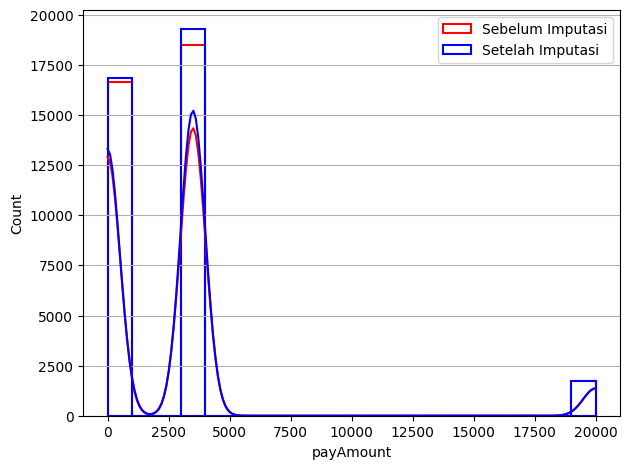

In [48]:
sns.histplot(tj_raw['payAmount'], kde=True, color='red', bins=20, fill=False, label='Sebelum Imputasi')
sns.histplot(df_tj['payAmount'], kde=True, color='blue', bins=20, fill=False, label='Setelah Imputasi')
plt.legend()
plt.grid(axis='y')

plt.tight_layout()

Hasil imputasi pada kolom `payAmount` tidak mengakibatkan perubahan pada distribusi data, dan perbedaan yang ada juga masih bisa kita toleransi.

In [49]:
display(df_tj.columns, df_tj.isna().sum())

Index(['transID', 'payCardID', 'payCardBank', 'payCardName', 'payCardSex',
       'payCardBirthDate', 'corridorName', 'direction', 'tapInStopsName',
       'tapInStopsLat', 'tapInStopsLon', 'stopStartSeq', 'tapInTime',
       'tapOutStopsName', 'tapOutStopsLat', 'tapOutStopsLon', 'stopEndSeq',
       'tapOutTime', 'payAmount'],
      dtype='object')

transID               0
payCardID             0
payCardBank           0
payCardName           0
payCardSex            0
payCardBirthDate      0
corridorName        174
direction             0
tapInStopsName        0
tapInStopsLat         0
tapInStopsLon         0
stopStartSeq          0
tapInTime             0
tapOutStopsName      46
tapOutStopsLat        0
tapOutStopsLon        0
stopEndSeq            0
tapOutTime            0
payAmount             0
dtype: int64

In [50]:
df_tj.loc[:,df_tj.isna().sum() > 0].columns

Index(['corridorName', 'tapOutStopsName'], dtype='object')

In [51]:
df_tj_missing = pd.DataFrame(df_tj[['corridorName','tapOutStopsName']].isna().sum()).rename(columns={0:'missingCount'})
df_tj_missing['missingPercentage'] = round((df_tj_missing['missingCount'] / len(df_tj)), 4) * 100
df_tj_missing

,missingCount,missingPercentage
corridorName,174,0.46
tapOutStopsName,46,0.12


Setelah kita selsai mencoba `SimpleImputer` dan `IterativeImputer`, kini *missing values* dataset kita hanya memiliki *missing values* dengan persentase dibawah 1%. Oleh karena itu, kita bisa gunakan `dropna()` sebagai opsi terakhir.

#### **DF Cleaned**

Sekarang kita `drop` **Null** yang tersisa, dan mari kita bandingkan hasil total entries dataset kita sesudah dan sebelum kita melakukan cleansing.

In [52]:
df = df_tj.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37726 entries, 0 to 37899
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transID           37726 non-null  object        
 1   payCardID         37726 non-null  int64         
 2   payCardBank       37726 non-null  object        
 3   payCardName       37726 non-null  object        
 4   payCardSex        37726 non-null  object        
 5   payCardBirthDate  37726 non-null  int64         
 6   corridorName      37726 non-null  object        
 7   direction         37726 non-null  float64       
 8   tapInStopsName    37726 non-null  object        
 9   tapInStopsLat     37726 non-null  float64       
 10  tapInStopsLon     37726 non-null  float64       
 11  stopStartSeq      37726 non-null  int64         
 12  tapInTime         37726 non-null  datetime64[ns]
 13  tapOutStopsName   37726 non-null  object        
 14  tapOutStopsLat    37726 non

<Axes: >

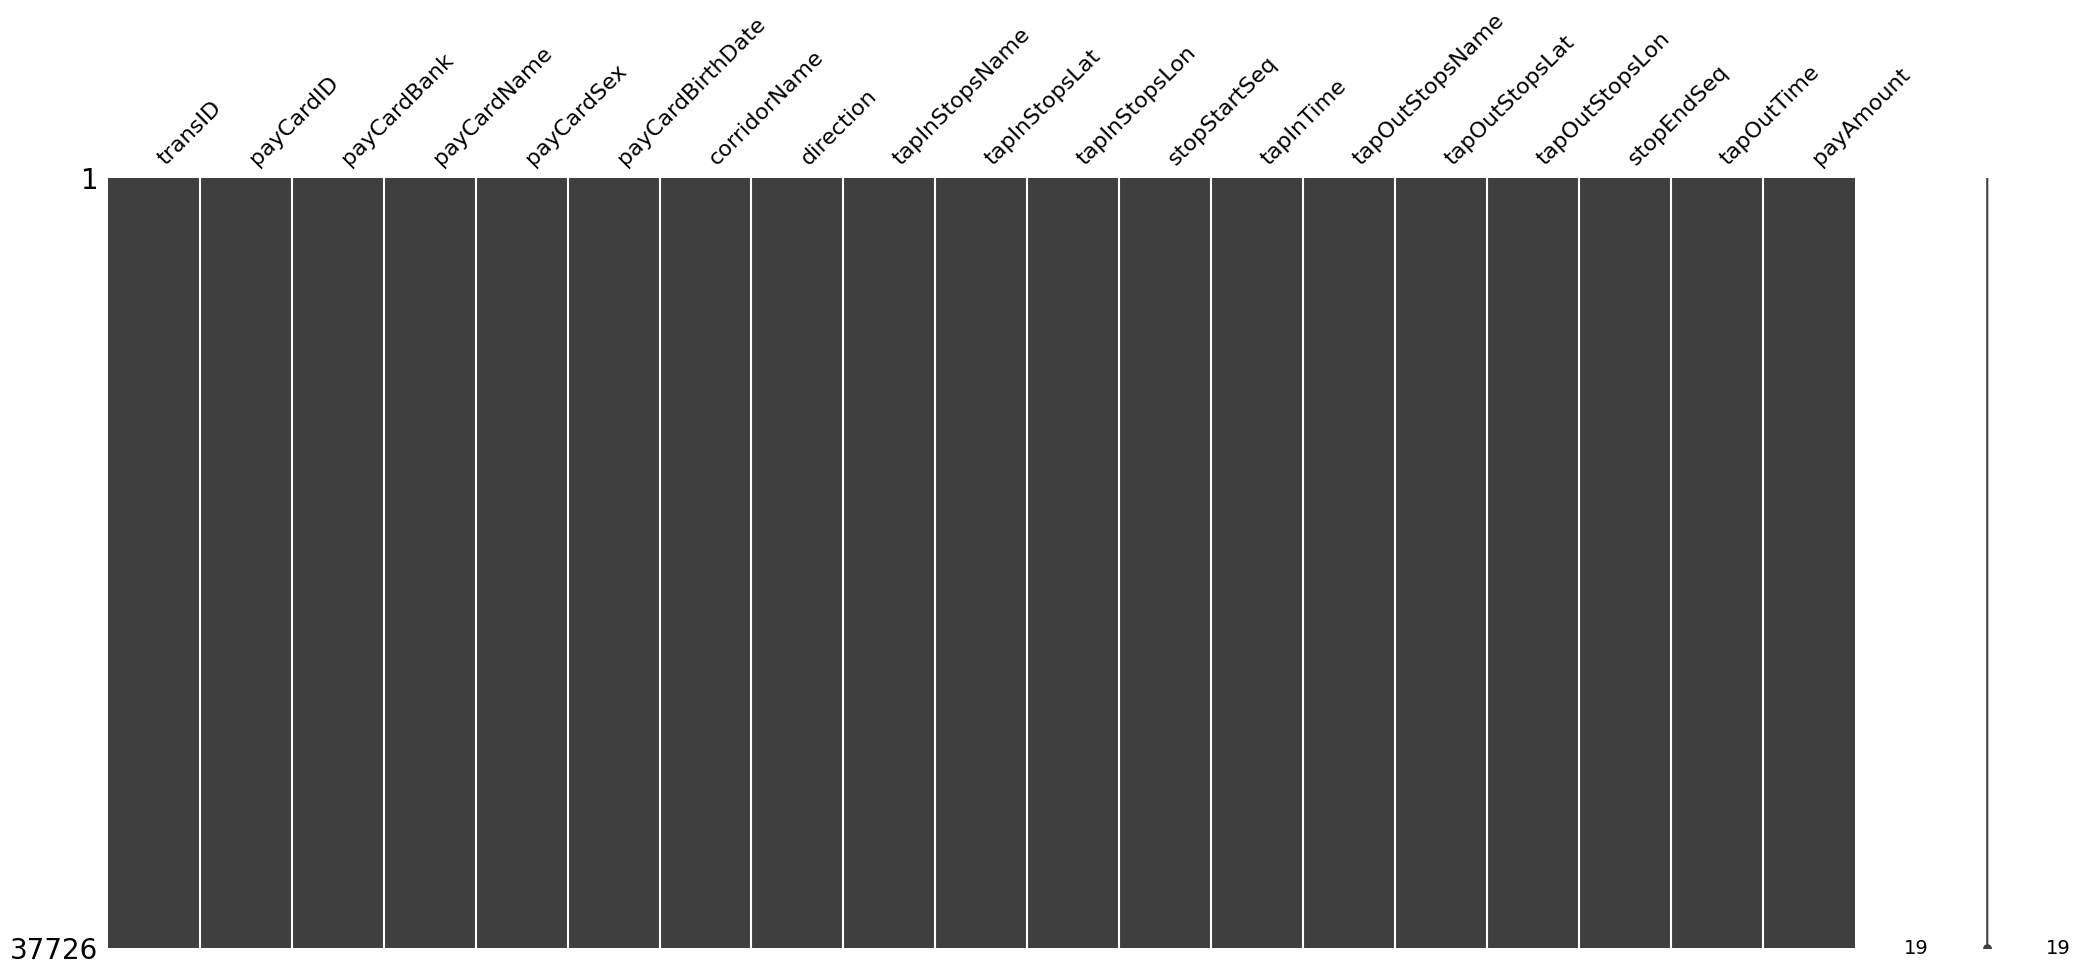

In [53]:
msno.matrix(df)

In [54]:
pd.set_option('display.max_colwidth', 60)
unique_items = []

for col in df.columns :
    unique_items.append( [col, df[col].nunique(), df[col].unique()])

raw_desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=unique_items)
raw_desc

,Column Name,Number of Unique,Unique Sample
0,transID,37726,"[EIIW227B8L34VB, LGXO740D2N47GZ, DJWR385V2U57TO, JTUZ800..."
1,payCardID,1982,"[180062659848800, 4885331907664776, 4996225095064169, 63..."
2,payCardBank,6,"[emoney, dki, flazz, online, brizzi, bni]"
3,payCardName,1975,"[Bajragin Usada, Gandi Widodo, Emong Wastuti, Surya Waca..."
4,payCardSex,2,"[M, F]"
5,payCardBirthDate,67,"[2008, 1997, 1992, 1978, 1982, 1993, 1974, 1991, 2004, 1..."
6,corridorName,216,"[Matraman Baru - Ancol, Stasiun Tebet - Karet via Patra ..."
7,direction,2,"[1.0, 0.0]"
8,tapInStopsName,2515,"[Pal Putih, Kemenkes 2, Gg. Kunir II, Taman Elok 1, Sunt..."
9,tapInStopsLat,2500,"[-6.184631, -6.2287, -6.133132, -6.195743, -6.14965, -6...."


In [55]:
df.isna().sum().sum()

np.int64(0)

Kita telah menyelesaikan proses *data cleansing* dan mari kita simpan hasil dataset yang sudah bersih menjadi file bernama `tj_cleaned.csv`

In [56]:
# df.to_csv('tj_cleaned.csv', index=False)

Kita telah pastikan tidak ada *record* yang duplikat dan terdapat *missing values*. Untuk proses analisis, kita juga tidak membutuhkan ID unik dari kolom `transID` dan `payCardID` karena tidak relevan, maka 2 kolom ini dapat kita `drop` saja.

In [57]:
df = df.iloc[:,2:]

In [58]:
df.sample(5)

,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
37672,dki,"Hj. Cindy Rajasa, M.Ak",F,1993,Ragunan - Dukuh Atas 2,1.0,SMK 57,-6.290967,106.823650,15,2023-04-09 15:35:16,Departemen Pertanian,-6.294641,106.822130,16,2023-04-09 18:15:27,3500.0
36810,dki,"Drs. Vicky Ardianto, S.Pd",F,1982,Harapan Indah - ASMI,1.0,Harapan Indah Boulevard,-6.186073,106.975020,26,2023-04-18 11:50:26,Gramedia Harapan Indah,-6.176310,106.974270,27,2023-04-18 13:36:42,3500.0
1704,emoney,Jelita Maryadi,M,1976,Pluit - Senen,0.0,Pluit 1,-6.115636,106.790900,0,2023-04-05 17:32:32,Landmark Pluit Auto Plaza,-6.125258,106.799710,4,2023-04-05 18:43:57,3500.0
18498,dki,Laras Salahudin,F,2003,Cilangkap - Cililitan,1.0,Jln. Dukuh II,-6.288462,106.875630,5,2023-04-11 09:28:50,Sbr. Jln. SMPN 160,-6.311787,106.889410,16,2023-04-11 10:59:24,0.0
26803,dki,Winda Habibi,M,2011,Pasar Minggu - Velbak,0.0,Jln. Pangeran Antasari III,-6.257481,106.807869,29,2023-04-21 18:47:38,Ps. Keramik Panglima Polim,-6.252307,106.797286,35,2023-04-21 20:18:20,3500.0


In [59]:
df.shape

(37726, 17)

In [60]:
print(f'Jumlah total entries sebelum proses cleansing = {len(tj_raw)}\n')
print(f'Jumlah total entries setelah proses cleansing = {len(df)}\n')
print(f'Persentase entries setelah proses cleansing = {round(len(df) / len(tj_raw) * 100, 2)}%')

Jumlah total entries sebelum proses cleansing = 37900

Jumlah total entries setelah proses cleansing = 37726

Persentase entries setelah proses cleansing = 99.54%


## **Data Analysis**

`Bagaimana cara mengalokasikan armada secara lebih efisien berdasarkan pola perjalanan penumpang bus Transjakarta?`

Sekarang kita akan memulai analisa kita dengan mencari pola perjalanan penumpang Transjakarta. Mari kita mulai dengan mencari rentang waktu dan rute terpadat dimana masyarakat menggunakan layanan Transjakarta. Pertama-tama, kita akan buat kolom baru bernama `hours` dengan meng-ekstrak dari kolom `tapInTime`.

In [61]:
df['hours'] = df['tapInTime'].dt.hour
df['hours'].dtype

dtype('int32')

Kemudian, kita juga buat kolom baru yaitu `travelTimeMnts` untuk mencari `durasi perjalanan` dari setiap penumpang dalam `satuan menit`.

In [62]:
df['travelTimeMnts'] = round((df['tapOutTime'] - df['tapInTime']).dt.total_seconds() / 60, 2)
df['travelTimeMnts'].dtype

dtype('float64')

In [63]:
df.sample(2)

,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount,hours,travelTimeMnts
28656,dki,"Ika Widiastuti, M.M.",M,1996,Rusun Sindang Koja - Kp. Sawah,1.0,Jln. B Lagoa Terusan 2,-6.108628,106.91505,13,2023-04-25 17:05:54,Jln. Lorong 19,-6.107881,106.897010,20,2023-04-25 18:41:36,0.0,17,95.7
24007,dki,Bakti Yuliarti,M,1998,Matraman Baru - Ancol,0.0,Pademangan,-6.133704,106.83164,13,2023-04-19 06:50:45,Ancol,-6.140232,106.832311,20,2023-04-19 08:01:45,3500.0,6,71.0


### Berdasarkan Durasi Perjalanan dan Rute Terpadat

1. Berapa lama rata-rata waktu perjalanan di setiap rute?
1. Apakah ada waktu tertentu di mana waktu perjalanan lebih lama dari biasanya?

In [64]:
# 10 rute dengan rata-rata durasi perjalanan terpanjang

rute_terlama = pd.DataFrame(df.groupby('corridorName')['travelTimeMnts'] \
               .mean().sort_values(ascending=False).head(10)).reset_index()
rute_terlama

,corridorName,travelTimeMnts
0,Kampung Rambutan - Blok M,84.985294
1,Cinere - Kuningan,82.376629
2,Stasiun Palmerah - Tosari,81.250872
3,Senen - Pulo Gadung via Kelapa Gading,79.859307
4,Rawamangun - Klender,79.730408
5,Puri Kembangan - Sentraland Cengkareng,79.698764
6,Pinang Ranti - Bundaran Senayan,79.539267
7,Rusun Pinus Elok - Rusun Pulo Gebang,79.499310
8,Tanah Abang - Kebayoran Lama via Pos Pengumben,79.314583
9,Grogol - Pos Pengumben via Slipi,78.645476


Tampaknya 3 peringkat teratas dari rute dengan rata-rata durasi perjalanan paling lama semuanya berada di ruas jalan area `Jakarta Selatan`. Mari kita visualisasikan dengan `bar chart` karena kita ingin melihat perbandingan rata-rata durasi perjalanan dari setiap rutenya.

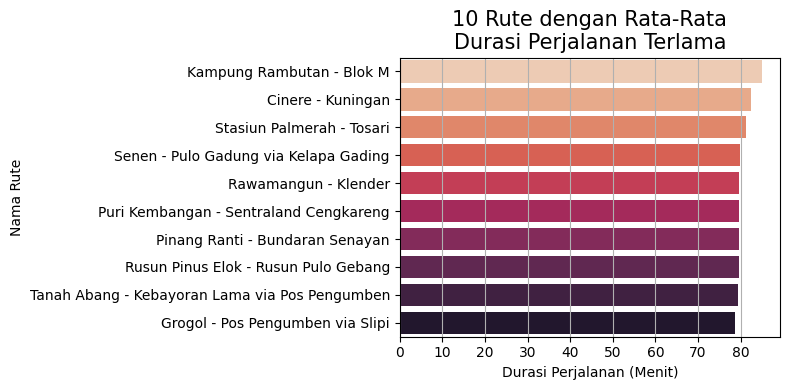

In [65]:
plt.figure(figsize=(8,4))
sns.barplot(rute_terlama, y='corridorName', x='travelTimeMnts', hue='corridorName', palette='rocket_r')
plt.title('10 Rute dengan Rata-Rata\nDurasi Perjalanan Terlama', size=15)
plt.xlabel('Durasi Perjalanan (Menit)')
plt.ylabel('Nama Rute')
plt.grid(axis='x')

plt.tight_layout();

Mengacu kepada [Google Maps direction](https://maps.app.goo.gl/W4R4qDaF7wd2Xqyv6), durasi perjalanan yang dibutuhkan untuk rute `Kampung Rambutan - Blok M yaitu sekitar 25-45 menit untuk kendaraan roda 2 maupun roda 4`. Perbedaan durasi perjalanan antara menggunakan kendaraan pribadi dengan layanan Transjakarta, memang menjadi sebuah pertimbangan yang membuat masih banyak masyarakat yang lebih memilih untuk tetap menggunakan kendaraan pribadi untuk pilihan transportasi mereka sehari-hari.

Mari kita coba lihat apakah terdapat jam atau periode waktu tertentu setiap harinya, yang mempengaruhi panjangnya durasi perjalanan Transjakarta.

In [66]:
# Durasi perjalanan Transjakarta setiap hari

rute_terpadat = pd.crosstab(df['travelTimeMnts'],df['hours'])
rute_terpadat['Total'] = rute_terpadat.sum(axis=1)
rute_terpadat = rute_terpadat.sort_values('Total',ascending=False).head(10)
rute_terpadat

hours,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,Total
travelTimeMnts,,,,,,,,,,,,,,,,,,
71.00,115,213,111,93,88,8,5,5,5,7,12,118,200,93,86,76,65,1300
54.02,2,3,1,0,0,0,0,1,0,0,0,2,3,1,2,3,0,18
76.75,1,3,1,1,1,0,0,0,0,0,1,5,1,0,1,2,1,18
54.82,1,4,0,0,2,0,0,0,0,0,0,2,3,1,2,1,1,17
59.75,3,2,3,1,0,1,0,0,1,0,0,1,3,0,2,0,0,17
56.20,5,3,2,2,0,0,0,0,1,0,0,0,4,0,0,0,0,17
52.05,1,3,0,4,0,0,0,0,0,0,0,0,4,1,0,2,2,17
57.72,5,4,0,0,0,0,1,0,0,0,0,0,4,0,1,0,2,17
55.23,0,2,1,1,0,0,0,0,0,0,0,2,4,0,3,2,1,16


Tampaknya durasi perjalanan terlama (72 menit) terjadi di jam-jam tertentu saja (*rush hours*), mari kita coba visualisasikan dengan `line chart` agar dapat melihat durasi perjalanan Transjakarta.

In [67]:
rush_hours = pd.DataFrame(df.groupby('hours')['travelTimeMnts'].mean().sort_values())
rush_hours.tail(10)

,travelTimeMnts
hours,
10,70.597474
8,70.834890
13,71.015789
15,79.963949
19,83.016382
21,83.159530
18,83.314594
20,83.452255
17,83.453581


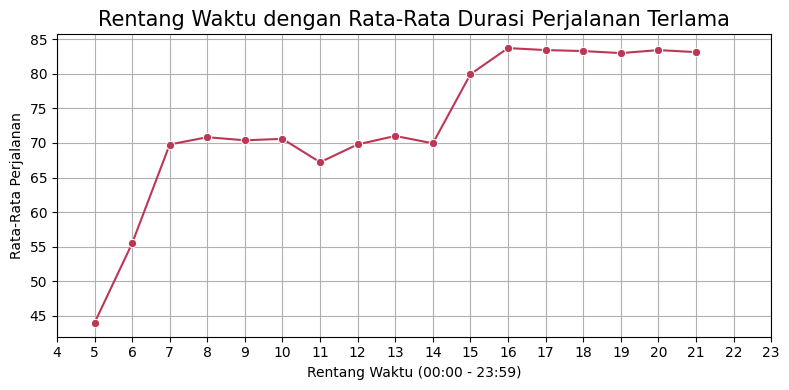

In [68]:
plt.figure(figsize=(8,4))
sns.lineplot(rush_hours, markers='o', palette='inferno', legend=False)
plt.xticks(range(4,24))
plt.xlabel('Rentang Waktu (00:00 - 23:59)')
plt.ylabel('Rata-Rata Perjalanan')
plt.title('Rentang Waktu dengan Rata-Rata Durasi Perjalanan Terlama', size=15)
plt.grid()

plt.tight_layout();

Lonjakan pertama terjadi mulai dari jam setengah 7 pagi, disaat masyarakat mulai beraktivitas, kemudian mencapai *rush hour* mulai dari jam 4 sore sampai 9 malam dengan rata-rata durasi perjalanan `paling tinggi` di angka `80-85 menit.`

### `Checkpoint`

Notes:

- Uji Statistik Pola Waktu Perjalanan
- Jam paling padat penumpang
- Durasi perjalanan
- Demografi penumpang
- Koridor/Rute terpadat

1. Pola perjalanan penumpang berdasarkan jam sibuk dan rute.
1. Kepadatan penumpang pada jam tertentu dan rute tertentu.
1. Durasi perjalanan rata-rata untuk berbagai rute dan waktu.
1. Segmentasi pengguna berdasarkan usia dan pola perjalanan.
1. Waktu dengan permintaan puncak, untuk menentukan kapan armada lebih banyak dibutuhkan.

In [69]:
df.groupby('corridorName')['travelTimeMnts'].max().sort_values(ascending=False).head(10)

corridorName
Cinere - Bundaran Senayan              179.05
Tanjung Priok - Senen via Taman BMW    179.05
Tanah Abang - Grogol via Tawakal       178.97
Tanjung Priok - PGC 2                  178.80
Rusun Marunda - Rusun Waduk Pluit      178.65
Rusun Pesakih - Kalideres              178.40
Pantai Maju - Balai Kota               177.95
Cibubur - Balai Kota                   177.63
Kp. Rambutan - Kalisari                177.25
Cililitan - Kp. Pulo                   177.17
Name: travelTimeMnts, dtype: float64

In [70]:
df.groupby('hours')['travelTimeMnts'].count().sort_values(ascending=False).head(10)

hours
6     5832
17    5481
16    3348
5     3346
8     2869
9     2800
7     2798
19    2449
18    2425
20    2399
Name: travelTimeMnts, dtype: int64

In [71]:
df['corridorName'].value_counts().sort_values(ascending=False).head(10)

corridorName
Cibubur - Balai Kota                           410
Ciputat - CSW                                  395
Pulo Gadung - Monas                            356
Harmoni - Jakarta International Stadium        352
Kalideres - Bundaran HI via Veteran            349
Kebayoran Lama - Tanah Abang                   346
Kampung Rambutan - Pondok Gede                 343
Rusun Pondok Bambu - Walikota Jakarta Timur    338
Pasar Minggu - Tanah Abang                     327
Rusun Rawa Bebek - Kodamar                     323
Name: count, dtype: int64

In [72]:
df.sample(2)

,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount,hours,travelTimeMnts
34819,emoney,"Tgk. Salwa Wahyudin, M.Kom.",F,1991,Bintaro - Fatmawati,0.0,Bintaro Xchange,-6.286813,106.72865,0,2023-04-13 12:48:37,St. MRT Fatmawati,-6.292589,106.79360,2,2023-04-13 13:46:43,20000.0,12,58.10
11365,dki,"Zizi Santoso, M.Kom.",M,1970,Kalideres - Bundaran HI via Veteran,1.0,Monas,-6.176248,106.82286,13,2023-04-27 16:28:09,MH Thamrin,-6.188149,106.82299,15,2023-04-27 17:18:23,3500.0,16,50.23


In [73]:
df['age'] = (2023 - df['payCardBirthDate']).astype(int)

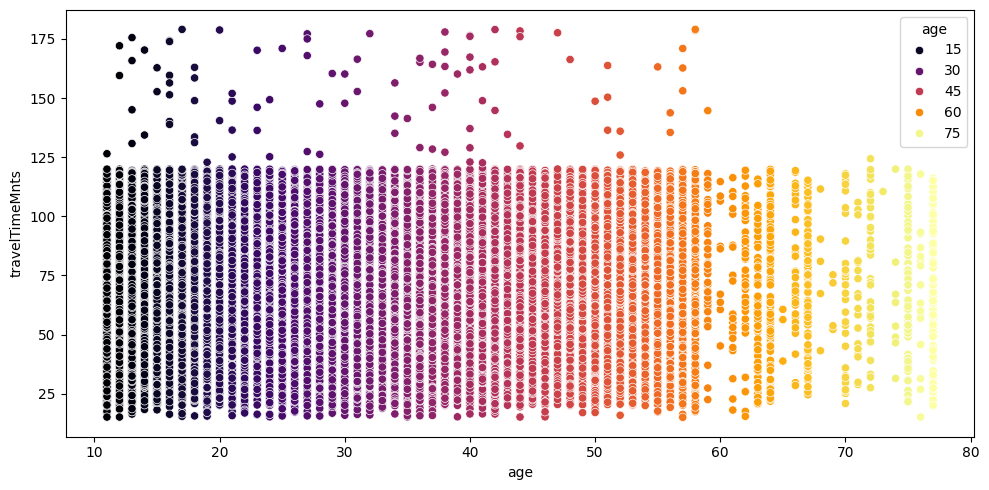

In [74]:
plt.figure(figsize=(10,5))
sns.scatterplot(df[['age','travelTimeMnts']], y='travelTimeMnts', x='age', hue='age', palette='inferno')

plt.tight_layout();

In [75]:
df['travelTimeMnts'].describe()

count    37726.000000
mean        72.078906
std         27.570161
min         15.000000
25%         51.722500
50%         71.000000
75%         94.900000
max        179.050000
Name: travelTimeMnts, dtype: float64

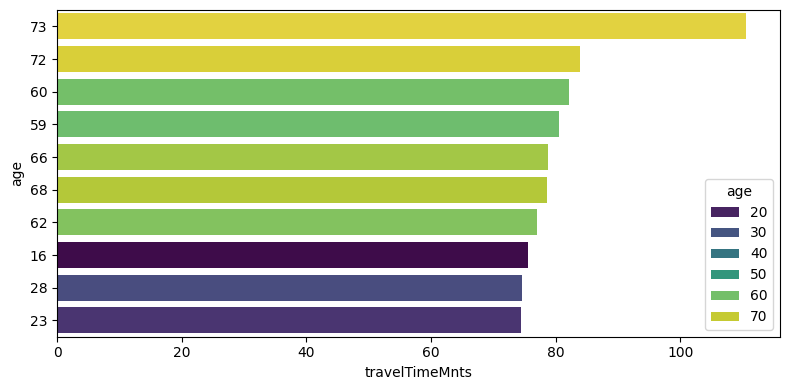

In [76]:
test_age = pd.DataFrame(df.groupby('age')['travelTimeMnts'].mean().sort_values(ascending=False).head(10)).reset_index()
# test_age

plt.figure(figsize=(8,4))
sns.barplot(test_age, y='age', x='travelTimeMnts', orient='h', palette='viridis', hue='age', order=test_age['age'])

plt.tight_layout();

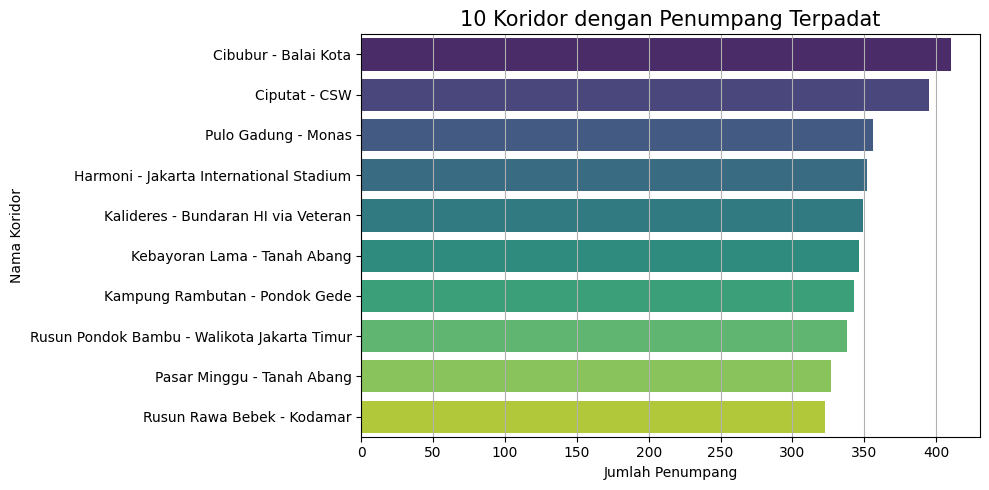

In [77]:
plt.figure(figsize=(10,5))
sns.barplot(df['corridorName'].value_counts().head(10), orient='h', palette='viridis')
plt.ylabel('Nama Koridor')
plt.xlabel('Jumlah Penumpang')
plt.grid(axis='x')
plt.title('10 Koridor dengan Penumpang Terpadat', size=15)

plt.tight_layout();

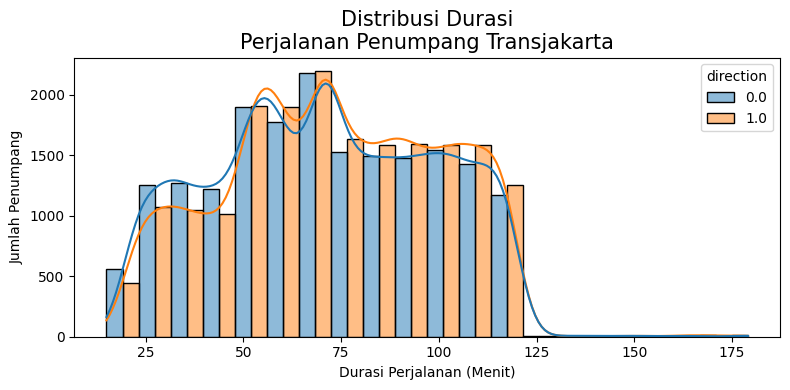

In [78]:
plt.figure(figsize=(8,4))
sns.histplot(df, x='travelTimeMnts', kde=True, hue='direction', bins=20, multiple='dodge')
plt.xlabel('Durasi Perjalanan (Menit)')
plt.ylabel('Jumlah Penumpang')
plt.title('Distribusi Durasi\nPerjalanan Penumpang Transjakarta', size=15)

plt.tight_layout();

In [79]:
pause

NameError: name 'pause' is not defined

In [ ]:
df

,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount,hours,travelTimeMnts
0,emoney,Bajragin Usada,M,2008,Matraman Baru - Ancol,1.0,Pal Putih,-6.184631,106.84402,7,2023-04-03 05:21:44,Tegalan,-6.203101,106.85715,12,2023-04-03 06:00:53,3500.0,5,39.15
1,dki,Gandi Widodo,F,1997,Stasiun Tebet - Karet via Patra Kuningan,0.0,Kemenkes 2,-6.228700,106.83302,13,2023-04-03 05:42:44,Sampoerna Strategic,-6.217152,106.81892,21,2023-04-03 06:40:01,3500.0,5,57.28
2,dki,Emong Wastuti,F,1992,Pantai Maju - Kota,0.0,Gg. Kunir II,-6.133132,106.81435,38,2023-04-03 05:59:06,Simpang Kunir Kemukus,-6.133731,106.81475,39,2023-04-03 06:50:55,3500.0,5,51.82
3,flazz,Surya Wacana,F,1978,Pulo Gebang - Pulo Gadung 2 via PIK,0.0,Taman Elok 1,-6.195743,106.93526,23,2023-04-03 05:44:51,Raya Penggilingan,-6.183068,106.93194,29,2023-04-03 06:28:16,3500.0,5,43.42
4,flazz,Embuh Mardhiyah,M,1982,Tanjung Priok - Pluit,0.0,Sunter Boulevard Barat,-6.149650,106.88900,5,2023-04-03 06:17:35,Kali Besar Barat,-6.135355,106.81143,15,2023-04-03 06:57:03,3500.0,6,39.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37895,brizzi,Kamila Mahendra,F,2004,Ragunan - MH Thamrin via Semanggi,1.0,Tosari,-6.196892,106.82309,2,2023-04-21 18:18:37,SMK 57,-6.290967,106.82365,13,2023-04-21 19:55:49,3500.0,18,97.20
37896,dki,Titi Siregar,M,1974,Pinang Ranti - Pramuka,1.0,Garuda Taman Mini,-6.290154,106.88116,1,2023-04-18 21:52:31,Pinang Ranti,-6.291075,106.88634,2,2023-04-18 22:28:22,3500.0,21,35.85
37897,emoney,drg. Zahra Nashiruddin,F,1976,Cibubur - Balai Kota,1.0,Plaza Sentral,-6.216247,106.81676,12,2023-04-04 10:29:47,Buperta Cibubur,-6.370321,106.89628,14,2023-04-04 13:27:25,20000.0,10,177.63
37898,emoney,Ana Agustina,M,1976,Tanah Abang - Jembatan Lima,1.0,Museum Textile,-6.188656,106.80954,33,2023-04-15 19:59:26,JPO Blok G,-6.188861,106.81135,34,2023-04-15 20:27:50,0.0,19,28.40


<Axes: xlabel='travelTimeMnts', ylabel='Count'>

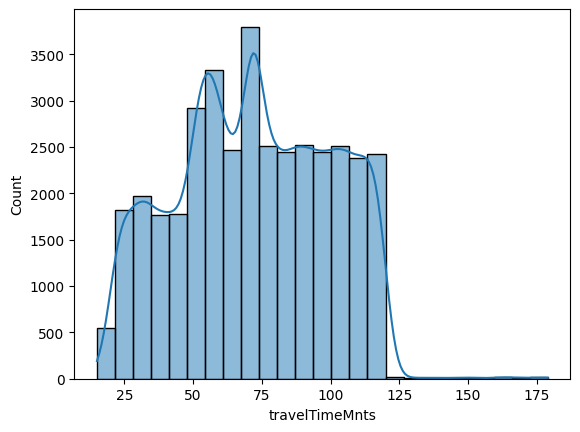

In [ ]:
sns.histplot(df['travelTimeMnts'], kde=True, bins=25)

In [ ]:
from scipy.stats import normaltest
stats, pval = normaltest(df['travelTimeMnts'])
if pval <= 0.05:
    print('Distribusi Tidak Normal')
else: 
    print('Distribusi Normal') 

Distribusi Tidak Normal


In [ ]:
# Mann WhitneyU

In [ ]:
df['direction'].value_counts()

direction
1.0    18874
0.0    18852
Name: count, dtype: int64

In [ ]:
df['payCardSex'].value_counts()

payCardSex
F    20066
M    17660
Name: count, dtype: int64

In [ ]:
display(
    df[(df['tapInTime'].dt.hour == 5) & (df['tapInTime'].dt.minute < 1)][:1],
    df[df['tapOutTime'].dt.hour < 4],
    df[df['tapInTime'].dt.hour == 21][-2:-1]
)

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
149,OVAQ760H7C61IE,4946777822784,online,Wirda Yuliarti,M,1990,Matraman Baru - Ancol,0.0,Slamet Riyadi,-6.208533,106.85929,1,2023-04-03 05:00:14,Budi Utomo,-6.166063,106.83906,9,2023-04-03 05:33:29,3500.0


,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
37615,JEES739W6T40LL,3563362178943707,dki,drg. Michelle Puspita,F,1968,Rusun Rawa Bebek - Kodamar,0.0,Gg. Sawo 1,-6.20176,106.93513,11,2023-04-24 21:46:56,Kayu Mas,-6.17911,106.90255,25,2023-04-25 00:30:08,0.0


,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
37896,YHHK837P6Y95GN,6502902290603767,dki,Titi Siregar,M,1974,Pinang Ranti - Pramuka,1.0,Garuda Taman Mini,-6.290154,106.88116,1,2023-04-18 21:52:31,Pinang Ranti,-6.291075,106.88634,2,2023-04-18 22:28:22,3500.0


`Menarik. Bahkan ada 1 penumpang yang baru tiba di tujuan di atas jam 12 malam, dengan waktu perjalanan 2 jam lebih.`

p.s itu dokter Michelle mau berangkat kemanasi berangkat malem-malem...

In [ ]:
df.sample()

,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount,hours,travelTimeMnts,age
5464,dki,Gangsa Widodo,M,1966,Rusun Pesakih - Kalideres,1.0,Pertamina Kalideres Daan Mogot,-6.15571,106.70927,2,2023-04-14 05:32:53,Rusun Pesakih,-6.161468,106.71698,4,2023-04-14 06:19:15,0.0,5,46.37,57


In [ ]:
test2 = pd.crosstab(df['age'], df['payCardSex'])
test2['Total'] = test2.sum(axis=1)
test2 = test2.sort_values('Total', ascending=False).head(10)
test2.reset_index(drop=True).transform()

payCardSex,F,M,Total
0,695,693,1388
1,718,653,1371
2,1056,295,1351
3,787,499,1286
4,786,463,1249
5,438,775,1213
6,679,501,1180
7,555,610,1165
8,712,424,1136
9,738,387,1125


array([<Axes: ylabel='age'>, <Axes: ylabel='F'>, <Axes: ylabel='M'>,
       <Axes: ylabel='Total'>], dtype=object)

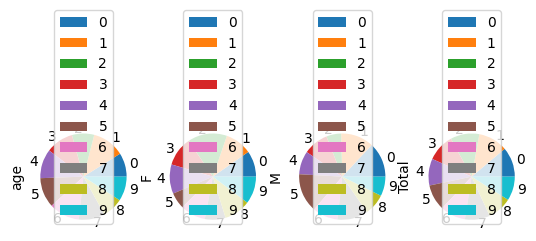

In [ ]:
test2.reset_index().plot(subplots=True, kind='pie')

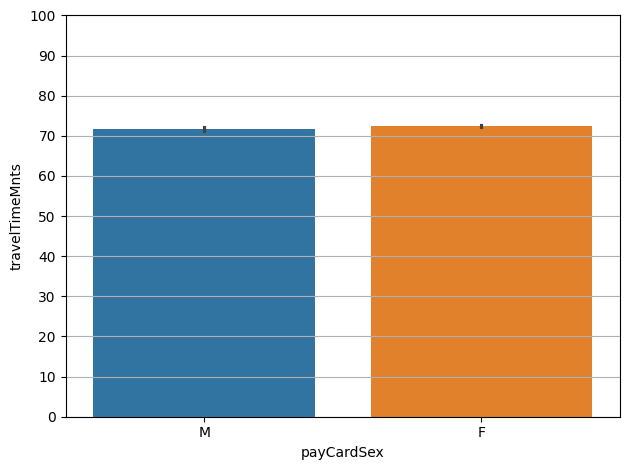

In [ ]:
sns.barplot(df, y='travelTimeMnts', x='payCardSex', hue='payCardSex', estimator='mean')
plt.yticks(range(0,101,10))
plt.grid(axis='y')

plt.tight_layout();

In [ ]:
df.sample(2)

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount,age,travelTimeMnts
8486,BKFA684R7K93VR,4000041838802,online,Diah Marpaung,M,2012,Rusun Rawa Bebek - Bukit Duri,0.0,Penggilingan,-6.214132,106.93961,2,2023-04-21 06:28:43,Perumnas Klender,-6.216689,106.93054,3,2023-04-21 07:18:20,0,13,49.62
21493,YKAH822S1W88JC,30437384286033,bni,Drs. Leo Mandala,F,1966,Rusun Cipinang Besar Selatan - Penas Kalimalang,0.0,TPU Kb. Nanas 2,-6.232106,106.88017,1,2023-04-14 08:11:37,STMT Trisakti 2,-6.231981,106.87770,2,2023-04-14 09:10:56,0,59,59.32


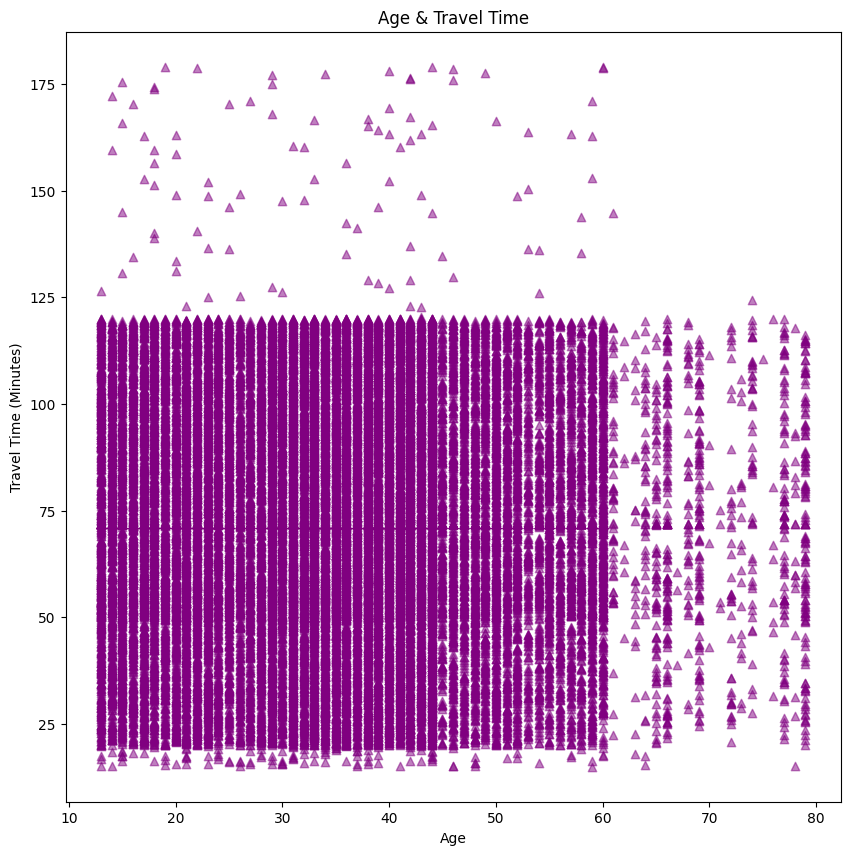

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(df['age'], df['travelTimeMnts'], alpha=0.5, marker='^', c='purple')
plt.title('Age & Travel Time')
plt.xlabel('Age')
plt.ylabel('Travel Time (Minutes)')
plt.show()

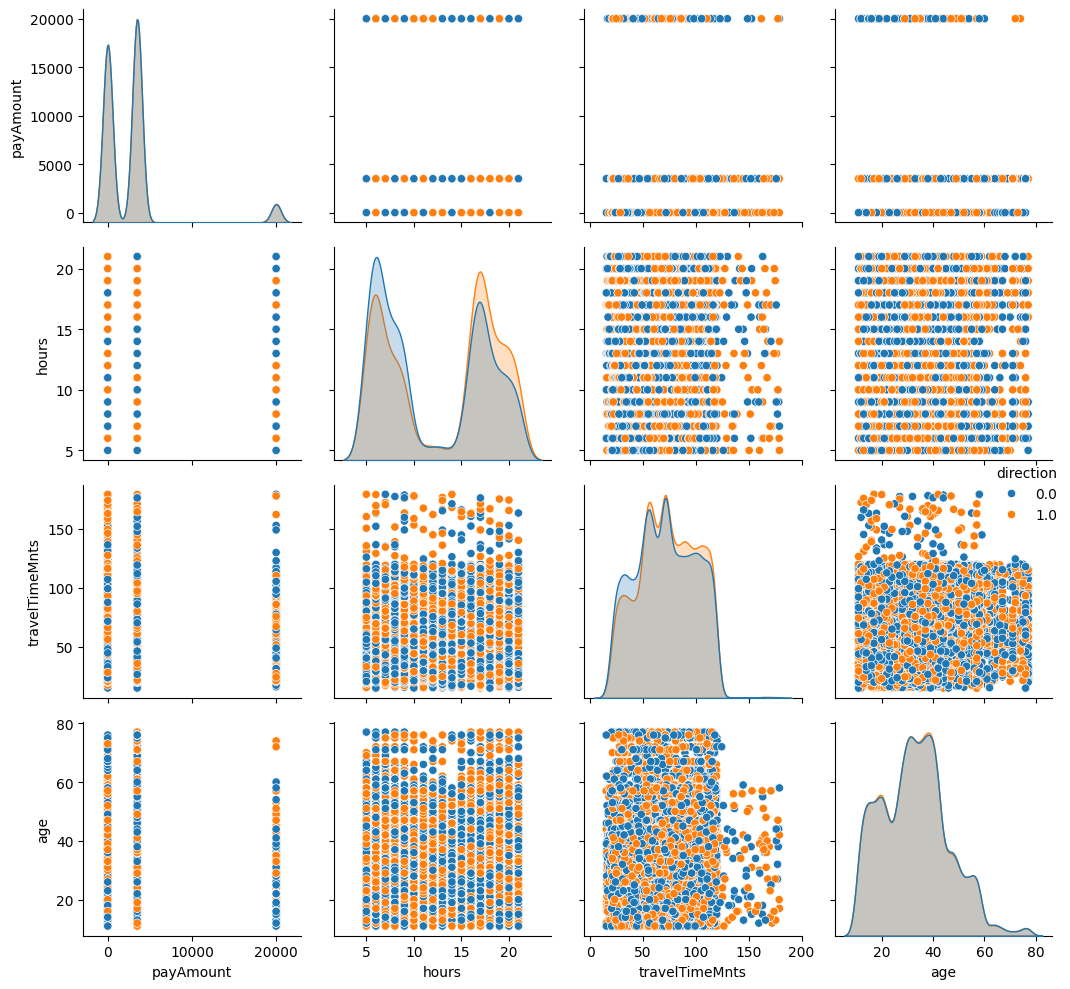

In [ ]:
sns.pairplot(df[[
   # 'payCardBank', 'payCardName', 'payCardSex', 'payCardBirthDate', 'corridorName', 
   'direction', 
   # 'tapInStopsName', 'tapInStopsLat', 'tapInStopsLon', 'stopStartSeq',
      #  'tapInTime', 'tapOutStopsName',
      #  'tapOutStopsLat', 'tapOutStopsLon', 'stopEndSeq', 
      #  'tapOutTime',
       'payAmount', 'hours', 'travelTimeMnts', 'age'
       ]], hue='direction')

plt.tight_layout();